<a href="https://colab.research.google.com/github/aakhterov/ML_algorithms_from_scratch/blob/master/machine_translation_using_bahdanau_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Description

We're going to build an NN model to translate from Russian to English. This notebook is committed to the implementation of the encoder-decoder network with Bahdanau attention (Additive Attention) mechanism.

We will use the following terms:
- source language - the language from which the model translates
- target language - the language to which the model translates
- token = word


Dataset: https://www.kaggle.com/datasets/hijest/englishrussian-dictionary-for-machine-translate/

References:
- https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/21_Machine_Translation.ipynb
- https://www.youtube.com/watch?v=vI2Y3I-JI2Q
- https://medium.com/analytics-vidhya/encoder-decoder-seq2seq-models-clearly-explained-c34186fbf49b
- https://blog.floydhub.com/attention-mechanism/#bahdanau-att-step2
- https://towardsdatascience.com/implementing-neural-machine-translation-with-attention-using-tensorflow-fc9c6f26155f



In [6]:
from typing import List
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
from string import punctuation
from collections import Counter
from tensorflow.keras.layers import Embedding, LSTM, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.utils import pad_sequences
from sklearn.model_selection import train_test_split

from google.colab import drive
drive.mount('/content/drive')
base_path = '/content/drive/MyDrive/Colab Notebooks/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# y_true = np.array([2])
# y_pred1 = np.array([[0.05, 0.05, 0.9]])
# y_pred2 = np.array([[0.1, 0.1, 0.8]])
# y_pred3 = np.array([[0.3, 0.3, 0.4]])
# loss1 = tf.losses.sparse_categorical_crossentropy(y_true, y_pred1)
# acc1 = tf.metrics.sparse_categorical_accuracy(y_true, y_pred1)

# loss2 = tf.losses.sparse_categorical_crossentropy(y_true, y_pred2)
# acc2 = tf.metrics.sparse_categorical_accuracy(y_true, y_pred2)

# loss3 = tf.losses.sparse_categorical_crossentropy(y_true, y_pred3)
# acc3 = tf.metrics.sparse_categorical_accuracy(y_true, y_pred3)

# print(f"loss1={loss1}, accuracy1={acc1}")
# print(f"loss2={loss2}, accuracy2={acc2}")
# print(f"loss3={loss3}, accuracy3={acc3}")

loss1=[0.10536052], accuracy1=[1.]
loss2=[0.22314355], accuracy2=[1.]
loss3=[0.91629073], accuracy3=[1.]


# 1. Vectorization

In [7]:
UNKNOWN_TOKEN = '[UNK]' # Out of vocabulary token
START_TOKEN = '[START]' # The token that denotes the beginning of the target language phrase
END_TOKEN = '[END]' # The token that denotes the end of the target language phrase

In [33]:
class Vectorization:
  '''
    Vectorization text class.
    Main goals:
     - make a vocabulary
     - convert the list of strings to the list of integer tokens
     - convert the list of integer tokens to the list of strings
  '''

  def __init__(self,
               max_tokens,
               max_length=None,
               unknown_token=UNKNOWN_TOKEN,
               start_token=START_TOKEN,
               end_token=END_TOKEN
               ):
    '''
      :param max_tokens: length of the vocabulary
      :param max_length: max length of the phrases
      :param unknown_token: out of vocabulary token
      :param start_token: token that denotes the beginning of the phrase
      :param end_token: token that denotes the end of the phrase
    '''
    self.max_tokens = max_tokens
    self.max_length = max_length
    self.unknown_token = unknown_token
    self.start_token = start_token
    self.end_token=end_token
    # add to the vocabulary:
    #  (1) padding token (we're going to pad using 0, so padding token index is 0)
    #  (2) out of vocabulary token
    #  (3) start token
    #  (4) end token
    self.vocabulary = ['', self.unknown_token, self.start_token, self.end_token]

  def __preprocessing(self, input: str) -> str:
    '''
      Preprocess of the string (convert to lowcase and remove punctuation).
      ex.: I'm going! -> i m going
      :param input - input string
      :return preprocessed string
    '''
    output = ''.join(map(lambda ch: ch if ch not in punctuation else ' ', input.lower())).strip()
    return output

  def token_to_text(self, tokens: List) -> str:
    '''
      Convert the list of the integer tokens to the string
      :param tokens: list of the integer tokens
      :return string contains words that correspond to the integer tokens
    '''
    words = [self.vocabulary[token] if token < len(self.vocabulary) else self.unknown_token for token in tokens]
    return " ".join(words)

  def fit(self, X: List, is_add_start_token=False, is_add_end_token=False):
    '''
      Make the vocabulary and calculate the max length of the phrase
      :param X: corpus - list of the strings
      :return the instance of the current class
    '''
    lens = []
    __vocab = []
    for x in X:
      # Make preprocessing and get the list of the words.
      # Ex. I'm going! -> ['i', 'm', 'going']
      words = self.__preprocessing(x).split()

      # Collect phrases lengths
      lens.append(len(words))

      # Make the vocabulary
      __vocab += [word.strip() for word in words]

      # for word in words:
      #   token = word.strip()
      #   # Add the word to the vocabulary if it usn't "full"
      #   if token not in self.vocabulary and self.max_tokens is not None and len(self.vocabulary)<self.max_tokens:
      #     self.vocabulary.append(token)

    c = Counter(__vocab)
    if self.max_tokens:
      self.vocabulary += [item[0] for item in c.most_common(self.max_tokens-4)]
    else:
      self.vocabulary += [item[0] for item in c.most_common()]

    # Calculate the max length of the phrases if it isn't set in the __init__
    # max_length = Average length + two standard devations
    lens = np.array(lens)
    if self.max_length is None:
      self.max_length = int(np.mean(lens) + 2 * np.std(lens)) + int(is_add_start_token) + int(is_add_end_token)
    return self

  def predict(self,
              X: List[str],
              is_padding=True,
              is_add_start_token=False,
              is_add_end_token=False
              ) -> List[List]:
    '''
      :param X - corpus - list of the strings
      :param is_padding - whether to pad the list of tokens to the max. length with 0s
      :param is_add_start_token - whether to add the start_token to the list of tokens
      :param is_add_end_token - whether to add the end_token to the list of tokens
      :return list of the lists of tokens
    '''
    output = []
    # max_length = self.max_length + int(is_add_start_token) + int(is_add_end_token)

    for x in X:
      # If nedded add the index of the start_token to the beginning of the list of tokens
      vector = [self.vocabulary.index(self.start_token)] if is_add_start_token else []

      # Make preprocessing and get the list of the words.
      words = self.__preprocessing(x).split()

      # If the current word is in the vocabulary add its index to the list else add the index of the unknown_token
      for word in words:
        token = word.strip()
        vector.append(self.vocabulary.index(token) if token in self.vocabulary else self.vocabulary.index(self.unknown_token))

      # Truncate the vector to the max. length
      vector = vector[:self.max_length-1]

      # If needed add the index of the end_token
      if is_add_end_token:
        vector.append(self.vocabulary.index(self.end_token))

      output.append(vector)

    # If needed pad the vector to the max. length with 0s
    return pad_sequences(output,
                         maxlen=self.max_length,
                         padding='post',
                         truncating='post') if is_padding else output

In [177]:
# Read from N to M samples
N = 200_000
M = 210_000

input_phrases, output_phrases = [], []
with open('/content/drive/MyDrive/Colab Notebooks/Data/rus.txt') as f:
  for line in f.readlines()[N:M]:
    eng, rus = line.split('CC-BY')[0].strip().split('\t')
    input_phrases.append(rus)
    output_phrases.append(eng)

In [178]:
input_vocab = 1_000 # size of the source language vocaulary
output_vocab = 1_000 # size of the target language vocaulary

In [179]:
# Make vectorization of the source language phrases
encoder_vec = Vectorization(max_tokens=input_vocab)
encoder_vec.fit(input_phrases)
X_encoder = encoder_vec.predict(input_phrases, is_padding=False)

# Make vectorization of the target language phrases
decoder_vec = Vectorization(max_tokens=output_vocab)
decoder_vec.fit(output_phrases, is_add_start_token=True, is_add_end_token=True)
# For the reason of the sequence model training we need decoder input contains the start_token and
# the decoder output which is without the start_token
X_decoder = decoder_vec.predict(output_phrases, is_add_start_token=True, is_add_end_token=True)
Y_decoder = decoder_vec.predict(output_phrases, is_add_end_token=True)

In [180]:
idx = 100
print(f"Index: {idx}")
print("======= Encoder =======")
print(f"Input phrase: {input_phrases[idx]}")
print(f"Vector: {X_encoder[idx]}")
print(f"Max. length: {encoder_vec.max_length}")
print("======= Decoder =======")
print(f"Input phrase: {output_phrases[idx]}")
print(f"Vector: {X_decoder[idx]}")
print(f"Output phrase: {output_phrases[idx]}")
print(f"Vector: {Y_decoder[idx]}")
print(f"Max. length: {decoder_vec.max_length}")
print("==============")
print(f"Start phrase token index: {decoder_vec.vocabulary.index(START_TOKEN)}")
print(f"End phrase token index: {decoder_vec.vocabulary.index(END_TOKEN)}")

Index: 100
======= Encoder =======
Input phrase: Для чего используется этот предмет?
Vector: [105, 124, 1, 107, 1]
Max. length: 7
======= Decoder =======
Input phrase: What is this object used for?
Vector: [  2  21  16  25   1 255  31   3   0   0]
Output phrase: What is this object used for?
Vector: [ 21  16  25   1 255  31   3   0   0   0]
Max. length: 10
Start phrase token index: 2
End phrase token index: 3


# 2. Construct Encoder-Decoder model with Bahdanau attention

## 2.1. Encoder model

In [181]:
class Encoder(tf.keras.Model):
  '''
    Encoder for using with Bahdanau attention
  '''
  def __init__(self, input_vocab: int, embedding_dim: int, lstm_hidden_units: int):
    '''
      :param input_vocab - vocabluary dimension of the source language
      :param embedding_dim - dimension of the source language words embeddings
      :param lstm_hidden_units - the number of the LSTM cell units
    '''
    super(Encoder, self).__init__()
    self.emedding = Embedding(input_dim=input_vocab,
                              output_dim=embedding_dim,
                              mask_zero=True,
                              name='encoder_embedding')
    self.lstm = LSTM(units=lstm_hidden_units,
                     return_state=True,
                     name='encoder_lstm')

  def __call__(self, x, is_verbose=False):
    '''
      Calculate forward propagation through the Encoder
      :param x - input sequence (batch_size, sequence_length)
    '''
    # Get embeddings.
    # 'x' dimension is (batch_size, sequence_length)
    # 'out' dimension is (batch_size, sequence_length, embedding_dim)
    out = self.emedding(x)

    # Hence we don't need LSTM output, we get only LSTM states (hidden state and cell state)
    # One of the problems here is that dispite the return_sequences parameter is True,
    # we get only last (after propagation a whole sequence) values of the states and
    # didn't get the states after each timestep. We will struggle with this later.
    output, h, c = self.lstm(out)

    if is_verbose:
      print(f"Input shape {x.shape}. Shape after embedding: {out.shape}.")
      print(f"Output LSTM shape: {output.shape}. Hidden state: {h.shape}. Cell state: {c.shape}")

    return h, c

In [182]:
# Test Encoder
enc = Encoder(input_vocab=100, embedding_dim=64, lstm_hidden_units=16)
input = np.zeros((4, 3))
h, c = enc(input, is_verbose=True)

assert input.shape == (4, 3), "Wrong input shape"
assert h.shape == (4, 16), "Wrong hidden state shape"
assert c.shape == (4, 16), "Wrong cell state shape"

Input shape (4, 3). Shape after embedding: (4, 3, 64).
Output LSTM shape: (4, 16). Hidden state: (4, 16). Cell state: (4, 16)


## 2.2. Bahdanau Attention Layer

In [183]:
class BahdanauAttention(tf.keras.layers.Layer):
  '''
    Layers implements a Bahdanau attention mechanism
  '''
  def __init__(self, units: int, name=None):
    '''
      :param units - the number of the encoder and decoder hidden units.
      This value can be obtained from the inputs dimensions but for the purpose of simplicity we will set it here.
      :param name - tne name of the layer
    '''
    super(BahdanauAttention, self).__init__(name=name)
    self.fc_encoder_states = Dense(units=units, activation='linear')
    self.fc_decoder_states = Dense(units=units, activation='linear')
    self.fc_combined = Dense(units=1, activation='linear')

  def __call__(self, encoder_states, decoder_hidden_state, is_verbose=False):
    '''
      Calculate forward propagation through the Layer
      :param encoder_states - encoder hidden states (batch_size, sequence_length, encoder_lstm_hidden_units)
      :param decoder_hidden_state - decoder hidden state (batch_size, decoder_lstm_hidden_units)
    '''

    # Linear layer for the encoder hidden states (it has its own trainable weights).
    fc_encoder_out = self.fc_encoder_states(encoder_states) # fc_encoder_out dimension is (batch_size, sequence_length, encoder_lstm_hidden_units)

    # Linear layer for the decoder hidden state from the previous timestep (it has its own trainable weights).
    fc_decoder_out = self.fc_decoder_states(decoder_hidden_state) # fc_decoder_out dimension is (batch_size, decoder_lstm_hidden_units)

    # Add additional dimension to the fc_decoder_out
    fc_decoder_out = tf.expand_dims(fc_decoder_out, axis=1) # fc_decoder_out dimension is (batch_size, 1, decoder_lstm_hidden_units)

    # Calculate alignment score using linear layer  (it has its own trainable weights).
    # Alignment_scores dimension is (batch_size, sequence_length, 1)
    alignment_scores = self.fc_combined(tf.math.tanh(fc_encoder_out + fc_decoder_out))

    # Remove a redundant dimension: (batch_size, sequence_length, 1) -> (batch_size, sequence_length)
    # alignment_scores = np.squeeze(alignment_scores)

    # Calculate attention weights of the each encoder hidden state within a batch
    # softmax_alignment_scores dimension is (batch_size, sequence_length)
    softmax_alignment_scores = tf.nn.softmax(alignment_scores, axis=1)

    # Calculate context vector. Its dimension is (batch_size, encoder_lstm_hidden_units)
    context_vector = tf.reduce_sum(softmax_alignment_scores * encoder_states, axis=1)

    if is_verbose:
      print(f"Input: encoder_states shape: {encoder_states.shape}, decoder_hidden_state shape: {decoder_hidden_state.shape}")
      print(f"fc_encoder_out shape: {fc_encoder_out.shape}, fc_decoder_out shape: {fc_decoder_out.shape}")
      print(f"alignment_scores shape: {alignment_scores.shape}, softmax_alignment_scores shape: {softmax_alignment_scores.shape}")
      print(f"context_vector shape: {context_vector.shape}")

    return context_vector, softmax_alignment_scores

In [184]:
# Test BahdanauAttention Layer
ba = BahdanauAttention(units=64)
encoder_states = np.zeros((4, 3, 16))
decoder_hidden_state = np.zeros((4, 16))
context_vector, softmax_alignment_scores = ba(encoder_states, decoder_hidden_state, is_verbose=True)

assert encoder_states.shape == (4, 3, 16), "Wrong encoder hidden states shape"
assert decoder_hidden_state.shape == (4, 16), "Wrong decoder hidden state shape"
assert softmax_alignment_scores.shape == (4, 3, 1), "Wrong attention weights shape"
assert context_vector.shape == (4, 16), "Wrong context vector shape"

Input: encoder_states shape: (4, 3, 16), decoder_hidden_state shape: (4, 16)
fc_encoder_out shape: (4, 3, 64), fc_decoder_out shape: (4, 1, 64)
alignment_scores shape: (4, 3, 1), softmax_alignment_scores shape: (4, 3, 1)
context_vector shape: (4, 16)


## 2.3. Decoder model

In [185]:
class Decoder(tf.keras.Model):
  '''
    Decoder with Bahdanau attention mechanism
  '''
  def __init__(self, output_vocab, embedding_dim, lstm_hidden_units):
    '''
      :param output_vocab - vocabluary dimension of the target language
      :param embedding_dim - dimension of the target language words embeddings
      :param lstm_hidden_units - the number of the LSTM cell units
    '''
    super(Decoder, self).__init__()
    self.emedding = Embedding(input_dim=output_vocab,
                              output_dim=embedding_dim,
                              mask_zero=True,
                              name='decoder_embedding')

    self.lstm = LSTM(units=lstm_hidden_units,
                     return_sequences=True,
                     return_state=True,
                     name='decoder_lstm')

    self.attention = BahdanauAttention(units=lstm_hidden_units,
                                       name='decoder_attention')

    # Dense layer with softmax activation function
    self.output_dense = Dense(units=output_vocab,
                              activation='softmax',
                              name='decoder_output')

  def __call__(self, x, decoder_states, encoder_states, is_verbose=False):
    '''
      Calculate forward propagation through the Decoder
      :param x - input sequence (batch_size, sequence_length_of_target_lang)
      :param decoder_states - hidden and cell decoder states from the previous timestep (or last encoder states for the first timestep)
      Dimension ((batch_size, lstm_hidden_units), (batch_size, lstm_hidden_units))
      :param encoder_states - hidden encoder states from the each timesteps  (batch_size, sequence_length, lstm_hidden_units)
    '''
    # Unpack decoder states
    hidden_state, cell_state = decoder_states

    # Calculate contect vector based on Bahdanau attention mechanism
    # context_vector dimension is (batch_size, lstm_hidden_units)
    context_vector, attention_weights = self.attention(encoder_states, hidden_state)

    # Get target language embedding
    x_embd = self.emedding(x)

    # Concatenate context_vector with the next embedded token
    input = tf.concat([tf.expand_dims(context_vector, 1), x_embd], axis=-1)

    # Get LSTM outputs
    out_lstm, h, c = self.lstm(input, initial_state=decoder_states)

    # Propagate LSTM output through dense layer with softmax activation function
    out = self.output_dense(out_lstm)

    if is_verbose:
      print(f"Input: encoder_states shape: {encoder_states.shape}, input hidden state: {hidden_state.shape}, input cell state: {cell_state.shape}")
      print(f"context_vector shape: {context_vector.shape}, After embedding shape: {x_embd.shape}")
      print(f"LSTM input shape: {input.shape}, LSTM output shape: {out_lstm.shape}")
      print(f"LSTM output hidden state: {h.shape}, LSTM output cell state: {c.shape}")
      print(f"Output after softmax: {out.shape}")

    return out, h, c, attention_weights

In [186]:
# Test Decoder
dec = Decoder(output_vocab=100, embedding_dim=32, lstm_hidden_units=16)
x = np.zeros((4, 1))
decoder_states = tf.convert_to_tensor(np.zeros((4, 16)), dtype=tf.float32), tf.convert_to_tensor((np.zeros((4, 16))), dtype=tf.float32)
encoder_states = tf.convert_to_tensor(np.zeros((4, 3, 16)), dtype=tf.float32)
out, h, c, _ = dec(x=x, decoder_states=decoder_states, encoder_states=encoder_states, is_verbose=True)

Input: encoder_states shape: (4, 3, 16), input hidden state: (4, 16), input cell state: (4, 16)
context_vector shape: (4, 16), After embedding shape: (4, 1, 32)
LSTM input shape: (4, 1, 48), LSTM output shape: (4, 1, 16)
LSTM output hidden state: (4, 16), LSTM output cell state: (4, 16)
Output after softmax: (4, 1, 100)


## 2.4. Encoder-Decoder model

In [187]:
class Seq2SeqBahdanauAttention(tf.keras.Model):
  '''
  Encoder-Decoder network implements the Bahdanau attention mechanism
  '''
  def __init__(self,
               input_vocab,
               output_vocab,
               encoder_embd_dim,
               decoder_embd_dim,
               encoder_lstm_units,
               decoder_lstm_units,
               max_output_length,
               start_token_index,
               end_token_index):
    '''
      :param input_vocab - vocabluary dimension of the source language
      :param output_vocab - vocabluary dimension of the target language
      :param encoder_embd_dim - dimension of the source language words embeddings
      :param decoder_embd_dim - dimension of the target language words embeddings
      :param encoder_lstm_units - the number of the LSTM cell units
      :param decoder_lstm_units - the number of the LSTM cell units
      :param max_output_length - the maximum length of the output sequence
      :param start_token_index - index of the start token in the output vocabulary
      :param end_token_index - index of the end token in the output vocabulary

    '''
    super(Seq2SeqBahdanauAttention, self).__init__()
    self.encoder = Encoder(input_vocab=input_vocab,
                           embedding_dim=encoder_embd_dim,
                           lstm_hidden_units=encoder_lstm_units)
    self.decoder = Decoder(output_vocab=output_vocab,
                           embedding_dim=decoder_embd_dim,
                           lstm_hidden_units=decoder_lstm_units)
    self.max_output_length = max_output_length
    self.start_token_index = start_token_index
    self.end_token_index = end_token_index
    self.__loss_object = tf.keras.losses.SparseCategoricalCrossentropy(reduction='none')
    self.__metric_object = tf.keras.metrics.SparseCategoricalAccuracy()


  def __loss_function(self, true, pred):
    '''
     :param true - ground truth values. Shape (batch_size)
     :param pred - The predicted values. Shape (batch_size, len_of_output_vocab)
    '''
    loss = self.__loss_object(true, pred)
    mask = tf.expand_dims(tf.math.not_equal(true, 0), 1)
    mask = tf.cast(mask, dtype=loss.dtype)
    non_zero_count = tf.reduce_sum(mask)
    return tf.reduce_sum(loss*mask)/non_zero_count if non_zero_count else 0

  def __metric_function(self, true, pred):
    '''
     :param true - ground truth values. Shape (batch_size)
     :param pred - The predicted values. Shape (batch_size, len_of_output_vocab)
    '''
    mask = tf.math.not_equal(true, 0)
    self.__metric_object.update_state(true[mask], pred[mask])
    return self.__metric_object.result().numpy()

  def __forward(self, X_encoder, X_decoder=None, Y_decoder=None):
    '''
      Forward propagation
      :param X_encoder - input encoder sequence (source language) (batch_size, sequence_length_in_the_source_lang)
      :param X_decoder - input decoder sequence (target language) (batch_size, sequence_length_in_the_target_lang + 2)
      (ex. [start_token_index, word1_index, woprd2_index, end_token_index)
      :param Y_decoder - output decoder sequence (target language) (batch_size, sequence_length_in_the_target_lang + 1)
      (ex. [word1_index, woprd2_index, end_token_index)

      We use X_decoder=None and Y_decoder=None for the purpose of prediction
      We use X_decoder=None and Y_decoder is not None for the purpose of validation during training
    '''
    output = np.array([], dtype=np.int32)
    batch_size = X_encoder.shape[0]
    attention_weights = None
    encoder_states = []
    loss = 0
    accuracy = None

    # Here we deal with the mentioned earlier problem of getting encoder hidden states on each timestep.
    # As we mentoined before LSTM parameter 'return_sequences' doesn't affect on the hidden and cell states, i.e.
    # we can't get LSTM states after every timestep. Therefore we need do it manually. It means the following:
    # 1) we take the first token of the input sequence, propagate it through the encoder and save the LSTM states.
    # 2) we take the two first tokens of the input sequence, propagate them through the encoder and save the last LSTM states.
    # 3) We repeat step 2 adding the next token and save the last LSTM states.

    for t in range(X_encoder.shape[1]):
      h, c = self.encoder(X_encoder[:, :t+1])
      encoder_states.append(h)
    encoder_states = tf.stack(encoder_states, axis=1) # make tensor from the list

    # save the last encoder hidden and cell states, since they are the initial decoder states
    hidden_state = encoder_states[:, -1, :]
    cell_state = c

    if X_decoder is not None and Y_decoder is not None: # if we train network
      # for every timestep (i.e. every token) of the target language sequence
      for t in range(X_decoder.shape[1]):
        # Set the decoder_input to the t-th token of the decoder input sequence.
        # We use here the teacher forcing method for faster and efficient decoder training.
        # The method uses the ground true as the decoder input instead of the prediction
        # from the previous timestep. We need decoder_input to have the dimension (batch_size, 1)
        decoder_input = X_decoder[:, t:t+1]
        # print(decoder_input.shape)

        # Calculate decoder output and states. We
        out, hidden_state, cell_state, _ = self.decoder(x=decoder_input,
                                                        decoder_states=(hidden_state, cell_state),
                                                        encoder_states=encoder_states)

        tokens = np.argmax(out[:, 0, :], axis=1)
        output = np.hstack((output, tokens)) # Collect output tokens
        loss += self.__loss_function(Y_decoder[:, t], out) # Calculate loss function
        accuracy = self.__metric_function(Y_decoder[:, t], np.squeeze(out)) # Calculate accuracy
    else: # if we validate (calculate loss and accuracy on the test set) the network or make prediction
      current_step = 0 # current timestep

      # Set the first decoder input to the start token index. decoder_input dimension is (batch_size, )
      decoder_input = np.full((batch_size, 1), self.start_token_index)

      # Iterate till the maximum outpt length will be achieved.
      while current_step<self.max_output_length:
        out, hidden_state, cell_state, att_weights = self.decoder(x=decoder_input,
                                                                  decoder_states=(hidden_state, cell_state),
                                                                  encoder_states=encoder_states)
        if Y_decoder is not None: # if we validate the network
          loss += self.__loss_function(Y_decoder[:, current_step], out) # loss function
          accuracy = self.__metric_function(Y_decoder[:, current_step], np.squeeze(out)) # accuracy metric

        # Get the indexes of the predicted tokens. Dimension is (batch_size, )
        tokens = np.argmax(out[:, 0, :], axis=1)

        # Here we don't use teacher forcing, i.e. the output from the previous timestep
        # is the input for the current one.
        decoder_input = tf.expand_dims(tokens, 1)

        # Collect output tokens
        output = np.hstack((output, tokens))

        # Collect output attention weights
        attention_weights = np.hstack((attention_weights, att_weights[:, :, 0])) if attention_weights is not None else att_weights[:, :, 0]
        current_step += 1

      # Rehape attention weights to the shape (batch_size, max_output_length, input_sequence_length)
      attention_weights = attention_weights.reshape(batch_size, self.max_output_length, -1)

    # If it's not a inference we calculate loss function value over batch
    batch_loss = tf.reduce_sum(loss) / Y_decoder.shape[1] if Y_decoder is not None else None
    return output, loss, batch_loss, accuracy, attention_weights

  def __train_step(self, X_encoder, X_decoder, Y_decoder, learning_rate):
    '''
      Perform one train iteration

      :param X_encoder - input encoder sequence (source language) (batch_size, sequence_length_in_the_source_lang)
      :param X_decoder - input decoder sequence (target language) (batch_size, sequence_length_in_the_target_lang + 2)
      (ex. [start_token_index, word1_index, woprd2_index, end_token_index)
      :param Y_decoder - output decoder sequence (target language) (batch_size, sequence_length_in_the_target_lang + 1)
      (ex. [word1_index, woprd2_index, end_token_index)
      :param learning_rate - an optimizer learning rate
    '''
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    with tf.GradientTape() as tape:
      _, loss, batch_loss, accuracy, _ = self.__forward(X_encoder, X_decoder, Y_decoder)
      variables = self.encoder.trainable_variables + self.decoder.trainable_variables
      gradients = tape.gradient(loss, variables)
      optimizer.apply_gradients(zip(gradients, variables))
    return batch_loss, accuracy

  def __align_to_length(self, X, batch_size=32):
    '''
    Reorder dataset according the sample sequence lengths

    It's known that the Bahdanau attention mechanism requires all encoder hidden states.
    In general samples in the batch have different lengths, hence, they have different number of hidden states.
    So, a new problem arises - how can we store a batch with the different row lengths (row is a vector of the encoder hidden states).
    There are several ways to manage it. One of them can be transform the dataset so that each batch consists the
    sequences with the same lengths.

    :param X - dataset
    :param batch_size - batch size

    Ex.
    An original dataset X
    [
      [1, 2, 3],
      [4, 5, 6, 7],
      [8, 9],
      [10, 11, 12, 13],
      [14, 15, 16],
      [17, 18]
    ]
    batch_size = 2
    A new dataset
    [
      [1, 2, 3],
      [14, 15, 16],
      [4, 5, 6, 7],
      [10, 11, 12, 13],
      [8, 9],
      [17, 18]
    ]
    So, after splitting into batches, each batch will contain the sequences with the same lengths
    '''
    c = Counter([len(x[0]) for x in X])
    X_new = []
    for length, count in c.most_common():
      if count >= batch_size:
        batches_count = count//batch_size
        X_new += list(filter(lambda x: len(x[0])==length, X))[:batches_count*batch_size]
    return X_new

  def __generate_batches(self, X, Y, batch_size=32):
    '''
     Batch generator.

     Each batch is the number of tuple: (Encoder_input, Decoder_input, Decoder_output a.k.a. ground truth)  )
     :param X - encoder and decoder inputs
     :param Y - decoder output
     :param batch_size - batch size
    '''
    X_encoder, X_decoder = zip(*X)
    ds = list(zip(X_encoder, X_decoder, Y))
    X_new = self.__align_to_length(ds, batch_size)
    X_encoder, X_decoder, Y_decoder = zip(*X_new)
    X_encoder, X_decoder, Y_decoder = list(X_encoder), list(X_decoder), list(Y_decoder)
    batches_count = len(X_encoder) // batch_size
    for i in range(batches_count):
      lower_idx, upper_idx = i*batch_size, (i+1)*batch_size
      yield np.array(X_encoder[lower_idx:upper_idx]), \
            np.array(X_decoder[lower_idx:upper_idx]), \
            np.array(Y_decoder[lower_idx:upper_idx])

  def fit(self, X_encoder, X_decoder, Y_decoder, epoch=20, batch_size=32, train_size=0.8, learning_rate=0.001, is_verbose=False):
    '''
      Train network

      :param X_encoder - input encoder sequence (source language) (batch_size, sequence_length_in_the_source_lang)
      :param X_decoder - input decoder sequence (target language) (batch_size, sequence_length_in_the_target_lang + 2)
      (ex. [start_token_index, word1_index, woprd2_index, end_token_index)
      :param Y_decoder - output decoder sequence (target language) (batch_size, sequence_length_in_the_target_lang + 1)
      :param epoch - the number of epochs
      :param batch_size - batch size
      :param train_size - train dataset size (0 <= train_size <= 1)
      :param learning_rate - an optimizer learning rate
    '''

    # Split input and outputs into train and test. We need to combine two inputs (encoder and decoder)
    X_train, X_test, Y_decoder_train, Y_decoder_test = train_test_split(list(zip(X_encoder, X_decoder)),
                                                                        Y_decoder,
                                                                        train_size=train_size)
    # Align the train and test datasets according to the batch_size and sequences lengths
    X_new_train = self.__align_to_length(X_train, batch_size)
    X_new_test = self.__align_to_length(X_test, batch_size)

    # Calculate some usefull values
    total_train_batches = len(X_new_train) // batch_size
    total_test_batches = len(X_new_test) // batch_size
    train_ds_size = len(X_new_train)
    test_ds_size = len(X_new_test)

    # dictionary for saving the loss function and accuracy values
    history = {"train_loss": [], "train_accuracy": [], "test_loss": [], "test_accuracy": []}

    print(f"Train dataset: {total_train_batches} batches, {train_ds_size} samples")
    print(f"Test dataset: {total_test_batches} batches, {test_ds_size} samples")
    print(f"{'='*10}")

    # Iterate over epochs
    for ep in range(1, epoch+1):
      print(f"Epoch {ep}/{epoch}")

      # Train phase
      total_loss = 0
      self.__metric_object.reset_state()
        # Iterate over batches
      for batch, (X_batch_encoder,
                  X_batch_decoder,
                  Y_batch_decoder) in tqdm(enumerate(self.__generate_batches(X_train,
                                                                            Y_decoder_train,
                                                                            batch_size=batch_size)),
                                          desc=f"Train dataset"):
        # Propagate the batch through network and modify weights
        batch_loss, batch_accuracy = self.__train_step(X_batch_encoder, X_batch_decoder, Y_batch_decoder, learning_rate)

        total_loss += batch_loss
        accuracy = batch_accuracy

        if is_verbose:
          if batch%500==0 and batch!=0:
            print(f"Loss: {total_loss.numpy()/total_train_batches:.4f}. Accuracy: {accuracy:.4f}")

      total_loss /= total_train_batches
      history["train_loss"].append(total_loss.numpy())
      history["train_accuracy"].append(np.mean(accuracy))
      print(f"Loss on train: {total_loss.numpy():.4f} Accuracy on train: {accuracy:.4f}")

      # Test phase
      total_loss = 0
      self.__metric_object.reset_state()

      # Iterate over batches. We don't need decoder input here because we won't use teacher forcing
      for batch, (X_batch_encoder,
                  _,
                  Y_batch_decoder) in tqdm(enumerate(self.__generate_batches(X_test,
                                                                            Y_decoder_test,
                                                                            batch_size=batch_size)),
                                          desc=f"Test dataset"):
        _, _, batch_loss, batch_accuracy, _ = self.__forward(X_batch_encoder,
                                                             None,
                                                             Y_batch_decoder)
        total_loss += batch_loss
        accuracy = batch_accuracy

      total_loss /= total_test_batches
      history["test_loss"].append(total_loss.numpy())
      history["test_accuracy"].append(np.mean(accuracy))
      print(f"Loss on test: {total_loss.numpy():.4f} Accuracy on test: {accuracy:.4f}")
    return history

  def predict(self, X_encoder):
    '''
    Make prediction

    :param X_encoder - input encoder sequence (source language) (batch_size, sequence_length_in_the_source_lang)
    '''
    out, _, _, _, attention_weights = self.__forward(X_encoder)
    return out, attention_weights

# 3. Train the Encoder-Decoder model

In [188]:
embedding_dim = 256
lstm_hidden_units = 512

In [189]:
model = Seq2SeqBahdanauAttention(input_vocab=input_vocab,
                                 output_vocab=output_vocab,
                                 encoder_embd_dim=embedding_dim,
                                 decoder_embd_dim=embedding_dim,
                                 encoder_lstm_units=lstm_hidden_units,
                                 decoder_lstm_units=lstm_hidden_units,
                                 max_output_length=decoder_vec.max_length,
                                 start_token_index=decoder_vec.vocabulary.index(START_TOKEN),
                                 end_token_index=decoder_vec.vocabulary.index(END_TOKEN))

In [190]:
history = model.fit(X_encoder, X_decoder, Y_decoder, epoch=20, batch_size=32, train_size=0.8, learning_rate=0.001, is_verbose=True)

Train dataset: 247 batches, 7904 samples
Test dataset: 61 batches, 1952 samples
Epoch 1/20


Train dataset: 247it [08:11,  1.99s/it]


Loss on train: 3.4034 Accuracy on train: 0.2847


Test dataset: 61it [00:51,  1.19it/s]


Loss on test: 4.4468 Accuracy on test: 0.2563
Epoch 2/20


Train dataset: 247it [08:28,  2.06s/it]


Loss on train: 2.7314 Accuracy on train: 0.3867


Test dataset: 61it [01:00,  1.02it/s]


Loss on test: 3.9621 Accuracy on test: 0.2627
Epoch 3/20


Train dataset: 247it [09:15,  2.25s/it]


Loss on train: 2.4196 Accuracy on train: 0.4536


Test dataset: 61it [00:51,  1.18it/s]


Loss on test: 3.8606 Accuracy on test: 0.2748
Epoch 4/20


Train dataset: 247it [07:54,  1.92s/it]


Loss on train: 2.1669 Accuracy on train: 0.5065


Test dataset: 61it [00:49,  1.23it/s]


Loss on test: 3.8280 Accuracy on test: 0.2979
Epoch 5/20


Train dataset: 247it [07:57,  1.93s/it]


Loss on train: 1.9404 Accuracy on train: 0.5528


Test dataset: 61it [00:50,  1.20it/s]


Loss on test: 3.6526 Accuracy on test: 0.3218
Epoch 6/20


Train dataset: 247it [07:57,  1.93s/it]


Loss on train: 1.7405 Accuracy on train: 0.5940


Test dataset: 61it [00:49,  1.23it/s]


Loss on test: 3.5982 Accuracy on test: 0.3556
Epoch 7/20


Train dataset: 247it [07:54,  1.92s/it]


Loss on train: 1.5558 Accuracy on train: 0.6330


Test dataset: 61it [00:53,  1.14it/s]


Loss on test: 3.5114 Accuracy on test: 0.3665
Epoch 8/20


Train dataset: 247it [07:54,  1.92s/it]


Loss on train: 1.3852 Accuracy on train: 0.6686


Test dataset: 61it [00:48,  1.25it/s]


Loss on test: 3.5866 Accuracy on test: 0.3922
Epoch 9/20


Train dataset: 247it [07:58,  1.94s/it]


Loss on train: 1.2383 Accuracy on train: 0.7028


Test dataset: 61it [00:51,  1.19it/s]


Loss on test: 3.4215 Accuracy on test: 0.4079
Epoch 10/20


Train dataset: 247it [08:01,  1.95s/it]


Loss on train: 1.1054 Accuracy on train: 0.7337


Test dataset: 61it [00:51,  1.19it/s]


Loss on test: 3.4051 Accuracy on test: 0.4141
Epoch 11/20


Train dataset: 247it [08:12,  2.00s/it]


Loss on train: 0.9943 Accuracy on train: 0.7612


Test dataset: 61it [00:51,  1.18it/s]


Loss on test: 3.3787 Accuracy on test: 0.4243
Epoch 12/20


Train dataset: 247it [08:08,  1.98s/it]


Loss on train: 0.8936 Accuracy on train: 0.7857


Test dataset: 61it [00:51,  1.19it/s]


Loss on test: 3.3680 Accuracy on test: 0.4410
Epoch 13/20


Train dataset: 247it [08:09,  1.98s/it]


Loss on train: 0.8075 Accuracy on train: 0.8066


Test dataset: 61it [00:50,  1.20it/s]


Loss on test: 3.3597 Accuracy on test: 0.4578
Epoch 14/20


Train dataset: 247it [07:59,  1.94s/it]


Loss on train: 0.7319 Accuracy on train: 0.8257


Test dataset: 61it [00:50,  1.21it/s]


Loss on test: 3.3172 Accuracy on test: 0.4665
Epoch 15/20


Train dataset: 247it [07:59,  1.94s/it]


Loss on train: 0.6609 Accuracy on train: 0.8439


Test dataset: 61it [00:50,  1.21it/s]


Loss on test: 3.3089 Accuracy on test: 0.4732
Epoch 16/20


Train dataset: 247it [08:08,  1.98s/it]


Loss on train: 0.6067 Accuracy on train: 0.8584


Test dataset: 61it [00:50,  1.21it/s]


Loss on test: 3.2976 Accuracy on test: 0.4900
Epoch 17/20


Train dataset: 247it [08:18,  2.02s/it]


Loss on train: 0.5549 Accuracy on train: 0.8714


Test dataset: 61it [00:53,  1.13it/s]


Loss on test: 3.2898 Accuracy on test: 0.4963
Epoch 18/20


Train dataset: 247it [08:09,  1.98s/it]


Loss on train: 0.5121 Accuracy on train: 0.8819


Test dataset: 61it [00:49,  1.22it/s]


Loss on test: 3.1830 Accuracy on test: 0.5095
Epoch 19/20


Train dataset: 247it [08:02,  1.95s/it]


Loss on train: 0.4659 Accuracy on train: 0.8946


Test dataset: 61it [00:50,  1.21it/s]


Loss on test: 3.2473 Accuracy on test: 0.5208
Epoch 20/20


Train dataset: 247it [08:01,  1.95s/it]


Loss on train: 0.4266 Accuracy on train: 0.9039


Test dataset: 61it [00:52,  1.16it/s]

Loss on test: 3.2212 Accuracy on test: 0.5194


In [87]:
# with open(base_path + 'Data/machine_translation_bahdanau_attention_history.pickle', 'wb') as f:
#     pickle.dump(history, f)

In [ ]:
# with open(base_path + 'Data/machine_translation_bahdanau_attention_history.pickle', 'rb') as f:
#     history = pickle.load(f)

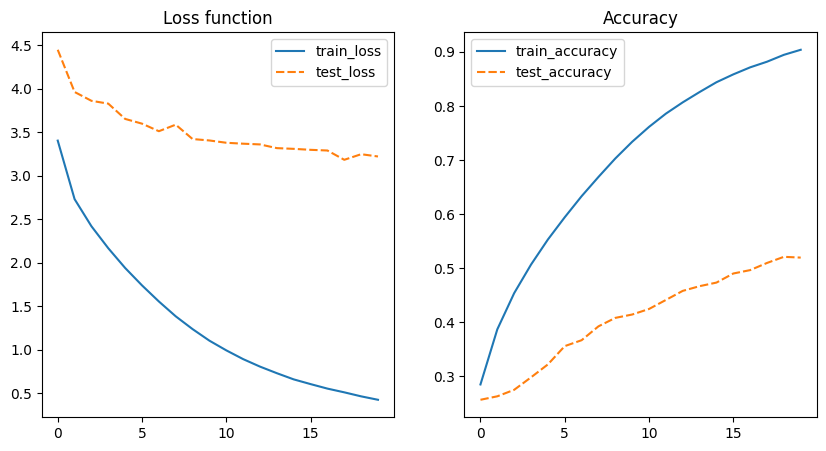

In [208]:
df = pd.DataFrame(data=history)
# Plot the learning curves (the loss function and the accuracy metric)
# which calculated on the training and test datasets
_, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.lineplot(data=df[['train_loss', 'test_loss']], ax=axs[0])
sns.lineplot(data=df[['train_accuracy', 'test_accuracy']], ax=axs[1])
axs[0].set_title('Loss function')
axs[1].set_title('Accuracy')
plt.show()

# 4. Inference

In [205]:
def predict(sentence: str, end_token_index: int) -> str:
  input = encoder_vec.predict([sentence])
  input = list(filter(lambda x: x!=0, input[0]))
  output, attention_weights = model.predict(np.array([input]))
  tokens, att_weights = [], []
  for idx, token in enumerate(output):
    if token == end_token_index:
      break
    tokens.append(token)
    att_weights.append(attention_weights[0][idx])
  return decoder_vec.token_to_text(tokens), att_weights

In [206]:
sentence = 'что это по твоему значит'
pred, att_weights = predict(sentence, 3)
print(pred)

what do you think that means


<Axes: >

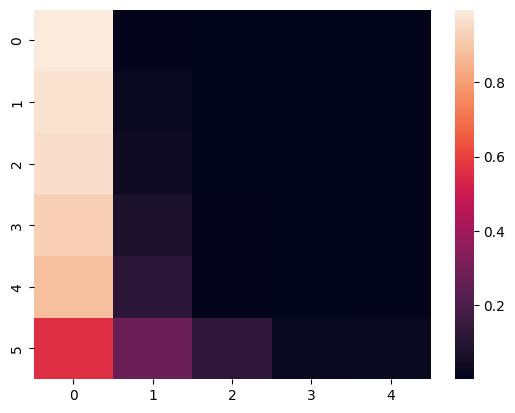

In [207]:
sns.heatmap(att_weights)